# Making a Decision

Recall, we have two fees schemas

1. the airport fines the airline **300$** per minute delayed. 

2. tiered fining

$$
\text{fees} =
    \begin{cases}
    &1,000 \quad \text{delay} < 10~\text{minutes} \\ 
    &5,000 \quad 10 <= \text{delay} < 100~\text{minutes} \\
    &30,000 \quad \text{delay} >= 100~\text{minutes}
    \end{cases}
$$

In [82]:
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

In [83]:
gumbel_data = az.from_json("../models/gumbel_data.json")
posterior_pred = gumbel_data.posterior_predictive["delay"].values.reshape(-1,336)

In [84]:
@np.vectorize
def fixed_revenue(delay):
    if delay >= 0:
        return 300 * delay
    return np.nan

In [85]:
@np.vectorize
def tiered_revenue(delay):
    if delay >= 100:
        return 30000.0
    elif delay >= 10:
        return 5000.0
    elif delay >= 0:
        return 1000.0
    else:
        return np.nan

In [86]:
def revenue_calculator(posterior_pred, revenue_func):    
    revenue_per_flight = revenue_func(posterior_pred)
    average_revenue = np.nanmean(revenue_per_flight)
    return revenue_per_flight, average_revenue

**For the fixed revenue model**

In [87]:
fixed_revenue_per_flight, fixed_average_revenue = revenue_calculator(posterior_pred, fixed_revenue)

The average estimate revenue is:

In [88]:
fixed_average_revenue

3940.463526358318

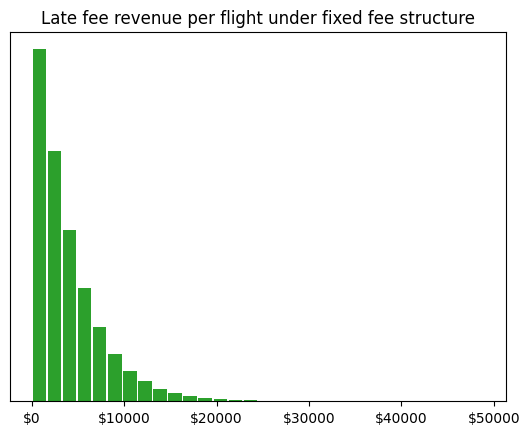

In [89]:
fig, ax = plt.subplots()
ax.hist(fixed_revenue_per_flight.flatten(), bins=30, rwidth=.9, color="C2" )
ax.set_yticks([])
ax.set_title("Late fee revenue per flight under fixed fee structure")
ax.xaxis.set_major_formatter('${x:1.0f}')

**For the fixed revenue model**

In [90]:
tiered_revenue_per_flight, tiered_average_revenue = revenue_calculator(posterior_pred, tiered_revenue)

The average estimate revenue is:

In [91]:
tiered_average_revenue

2930.3060416622616

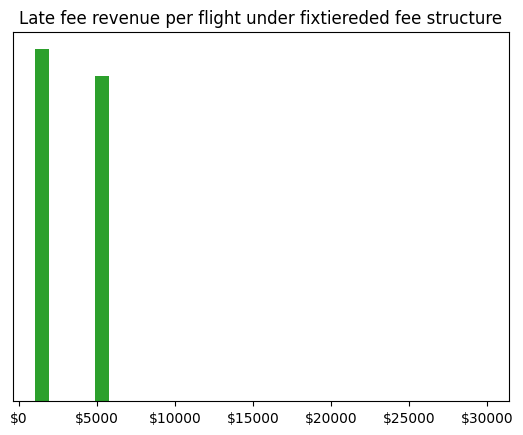

In [92]:
fig, ax = plt.subplots()
ax.hist(tiered_revenue_per_flight.flatten(), bins=30, rwidth=.9, color="C2" )
ax.set_yticks([])
ax.set_title("Late fee revenue per flight under fixtiereded fee structure")
ax.xaxis.set_major_formatter('${x:1.0f}')

In the new revenue structure we estimate that on average the airline will pay 2921.97 dollars per late flight, which is less than the current penalty pricing structure. 

We can also plot the revenue share under the new schema

In [93]:
counts = pd.Series(tiered_revenue_per_flight.flatten()).value_counts()
counts.index = counts.index.astype(int)

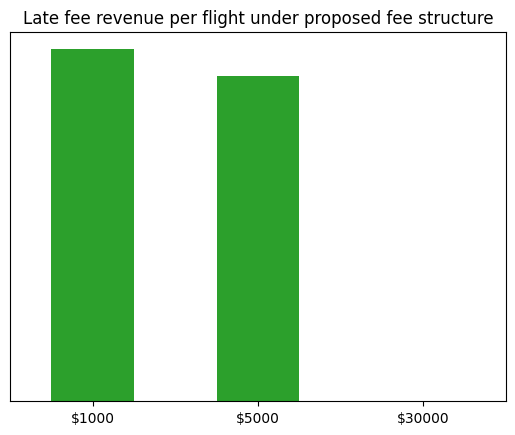

In [94]:
fig, ax = plt.subplots()


counts.plot(kind="bar", ax=ax, color="C2")
ax.set_title("Late fee revenue per flight under proposed fee structure")
ax.set_yticks([]);
ax.tick_params(axis='x', labelrotation = 0)
ax.set_xticklabels([f"${i}" for i in counts.index]);

In [95]:
revenue_proposed = tiered_revenue_per_flight.flatten()
revenue_proposed = revenue_proposed[~np.isnan(revenue_proposed)]
fees, cnts = np.unique(revenue_proposed, return_counts=True)
cnts = cnts/cnts.sum()
proposed_revenue_df = pd.DataFrame(zip(fees, cnts), columns=['Late Fee', 'Revenue'])
proposed_revenue_df['Late Fee'] = proposed_revenue_df['Late Fee'].apply(lambda x: "${:,.0f}".format((x)))
proposed_revenue_df['Revenue'] = proposed_revenue_df['Revenue'].apply(lambda x: "{:.2%}".format((x)))
proposed_revenue_df

,Late Fee,Revenue
0,"$1,000",51.95%
1,"$5,000",48.02%
2,"$30,000",0.03%


Hence, the airport should either reject the proposal, or negotiates a higher late fees for delays that lie within the 0 to 100 minutes.